### Basic Imports

In [1]:
import matplotlib.pyplot as plt
import torch

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Download some MNIST to demonstrate super-resolution
from torchvision import datasets, transforms
mnist = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())




100%|██████████| 9912422/9912422 [00:01<00:00, 5550029.74it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5586409.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2415755.96it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18918102.05it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Displaying an image
def show_image(img):
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')

# Displaying a batch of images
def show_batch(batch):
    grid = torch.cat([batch[i] for i in range(batch.shape[0])], dim=1)
    show_image(grid)
    

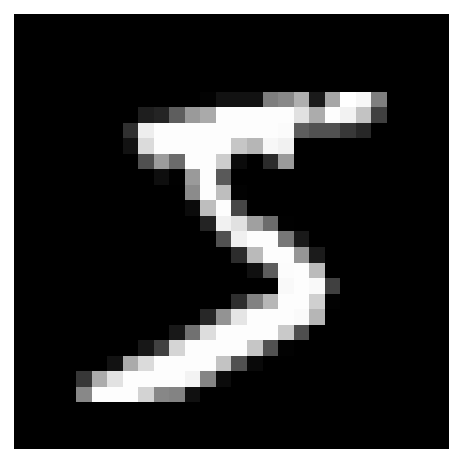

In [4]:
show_image(mnist[0][0])

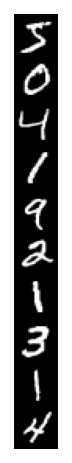

In [5]:
show_batch(torch.stack([mnist[i][0] for i in range(10)]))

In [6]:
mnist[0][0].shape

torch.Size([1, 28, 28])

In [9]:
# Downsample the images
downsample = transforms.Resize(7)

# First 1000 images
mnist_small = [downsample(mnist[i][0]) for i in range(1000)]
mnist_small = torch.stack(mnist_small)




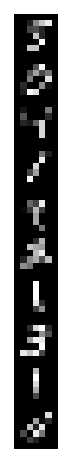

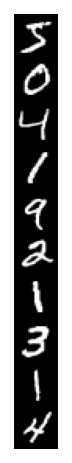

In [12]:
# Show the downsampled images and the original images side-by-side

show_batch(torch.stack([mnist_small[i] for i in range(10)]))
plt.figure()
show_batch(torch.stack([mnist[i][0] for i in range(10)]))

In [17]:
mnist_small.shape, mnist.data.shape

(torch.Size([1000, 1, 7, 7]), torch.Size([60000, 28, 28]))

In [124]:
import torch
import torch.nn as nn

class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

# Create an instance of the custom SinActivation module
sin_activation = SinActivation()

class UNet(nn.Module):
    def __init__(self, activation=sin_activation):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Input: (batch_size, 1, 7, 7), Output: (batch_size, 16, 7, 7)
            # Use the custom activation function
            activation,
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Input: (batch_size, 16, 7, 7), Output: (batch_size, 32, 7, 7)
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2)  # Input: (batch_size, 32, 7, 7), Output: (batch_size, 32, 3, 3)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input: (batch_size, 32, 3, 3), Output: (batch_size, 64, 3, 3)
            activation,
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=4, padding=0),  # Input: (batch_size, 64, 3, 3), Output: (batch_size, 32, 12, 12)
            activation,
            # Input (batch_size, 32, 12, 12), Output: (batch_size, 16, 12, 12)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            activation,
            # Input (batch_size, 16, 12, 12), Output: (batch_size, 1, 28, 28)
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
            
            )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Bottleneck
        x = self.bottleneck(x1)

        # Decoder
        x = self.decoder(x)

        return x

# Create an instance of the modified UNet model
model = UNet(nn.GELU())

# Print the model architecture with input and output shape
batch_size = 1
input_size = (batch_size, 1, 7, 7)
dummy_input = torch.randn(input_size)
output = model(dummy_input)
print(model)
print(f"Input shape: {input_size}")
print(f"Output shape: {output.shape}")


UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(4, 4))
    (1): GELU(approximate='none')
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Input shape: (1, 1, 7, 7)
Output shape: torch.Size([1, 1, 28, 28])


In [125]:
# Provide an example input to the model
batch_size = 1
input_size = (batch_size, 1, 7, 7)
dummy_input = torch.randn(input_size)

# Export the model to ONNX
onnx_path = "unet_model.onnx"
torch.onnx.export(model, dummy_input, onnx_path, verbose=True)

print("Model exported to ONNX successfully.")

Exported graph: graph(%input.1 : Float(1, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=0, device=cpu),
      %encoder.0.weight : Float(16, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.0.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %encoder.2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.2.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %bottleneck.0.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %bottleneck.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %decoder.0.weight : Float(64, 32, 4, 4, strides=[512, 16, 4, 1], requires_grad=1, device=cpu),
      %decoder.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %decoder.2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %decoder.2.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      

![](unet_model.onnx.svg)

In [126]:
# Input to the model is a batch of 1-channel 7x7 images
batch_size = 1
input_size = (batch_size, 1, 7, 7)

# Create an instance of the modified UNet model
model = UNet()

# Output of the model is a batch of 1-channel 28x28 images
output_size = (batch_size, 1, 28, 28)




In [127]:
X = mnist_small
X.shape

torch.Size([1000, 1, 7, 7])

In [128]:
X.dtype

torch.float32

In [129]:
Y = mnist.data[:1000].reshape(1000, 1, 28, 28)
Y = Y.float()
Y.shape

torch.Size([1000, 1, 28, 28])

In [130]:
Y

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [131]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train on full 100 samples

# Number of epochs
n_epochs = 5000

# List to store losses
losses = []

# Loop over epochs
for epoch in range(n_epochs):
    # Forward pass
    Y_pred = model(X)

    # Compute Loss
    loss = loss_fn(Y_pred, Y)

    # Print loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1} loss: {loss.item()}")

    # Store loss
    losses.append(loss.item())

    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update the weights
    optimizer.step()


Epoch 1 loss: 7117.515625
Epoch 101 loss: 4315.5869140625
Epoch 201 loss: 2911.161865234375
Epoch 301 loss: 2186.302490234375
Epoch 401 loss: 1815.713623046875
Epoch 501 loss: 1514.586181640625
Epoch 601 loss: 1323.70068359375
Epoch 701 loss: 1192.3692626953125
Epoch 801 loss: 1038.9659423828125
Epoch 901 loss: 941.296630859375
Epoch 1001 loss: 867.8710327148438
Epoch 1101 loss: 785.0245971679688
Epoch 1201 loss: 730.25830078125
Epoch 1301 loss: 700.0931396484375


KeyboardInterrupt: 

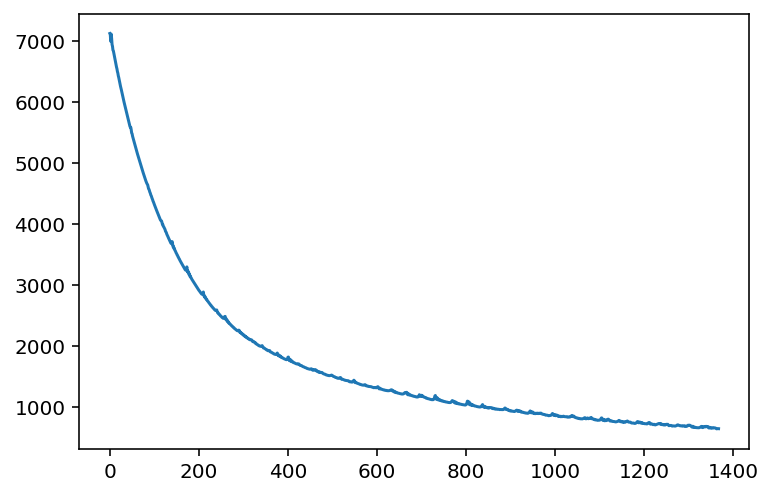

In [132]:
# Plot the losses
plt.plot(losses)

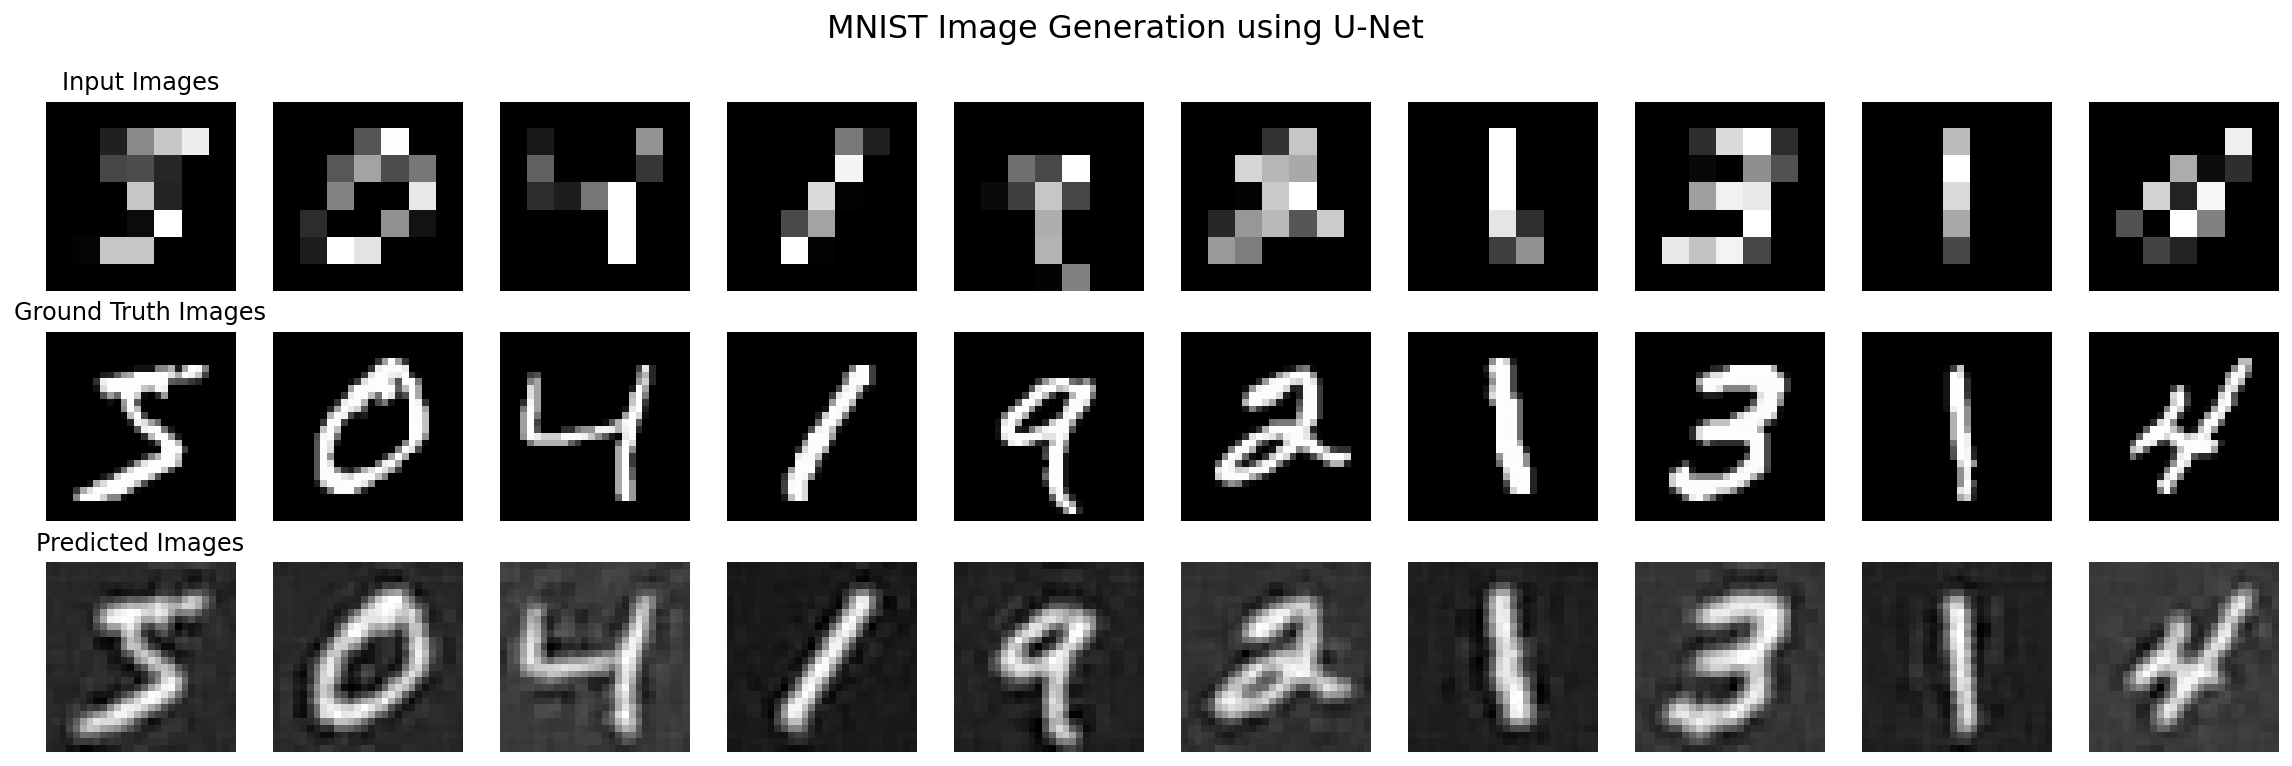

In [142]:
# Extract a mini-batch of 10 images
X_mini = X[:10]
Y_mini = Y[:10]

# Forward pass
Y_hat = model(X_mini)

def plot_images(X_mini, Y_mini, Y_hat=None):

    # Plot 3 rows
    rows = 3

    # 10 images X 3 
    # First row: 10 images from the mini-batch
    # Second row: 10 ground truth images
    # Third row: 10 predicted images

    fig, ax = plt.subplots(rows, 10, figsize=(20, 6))

    for i in range(rows):
        for j in range(10):
            if i == 0:
                ax[i][j].imshow(X_mini[j].squeeze(), cmap="gray")
            elif i == 1:
                ax[i][j].imshow(Y_mini[j].squeeze(), cmap="gray")
            else:
                ax[i][j].imshow(Y_hat[j].detach().squeeze(), cmap="gray")

            ax[i][j].axis("off")

    # Put labels for the three rows using suptitle()
    fig.suptitle("MNIST Image Generation using U-Net", fontsize=16)

    ax[0][0].set_title("Input Images")
    ax[1][0].set_title("Ground Truth Images")
    ax[2][0].set_title("Predicted Images")

plot_images(X_mini, Y_mini, Y_hat)


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


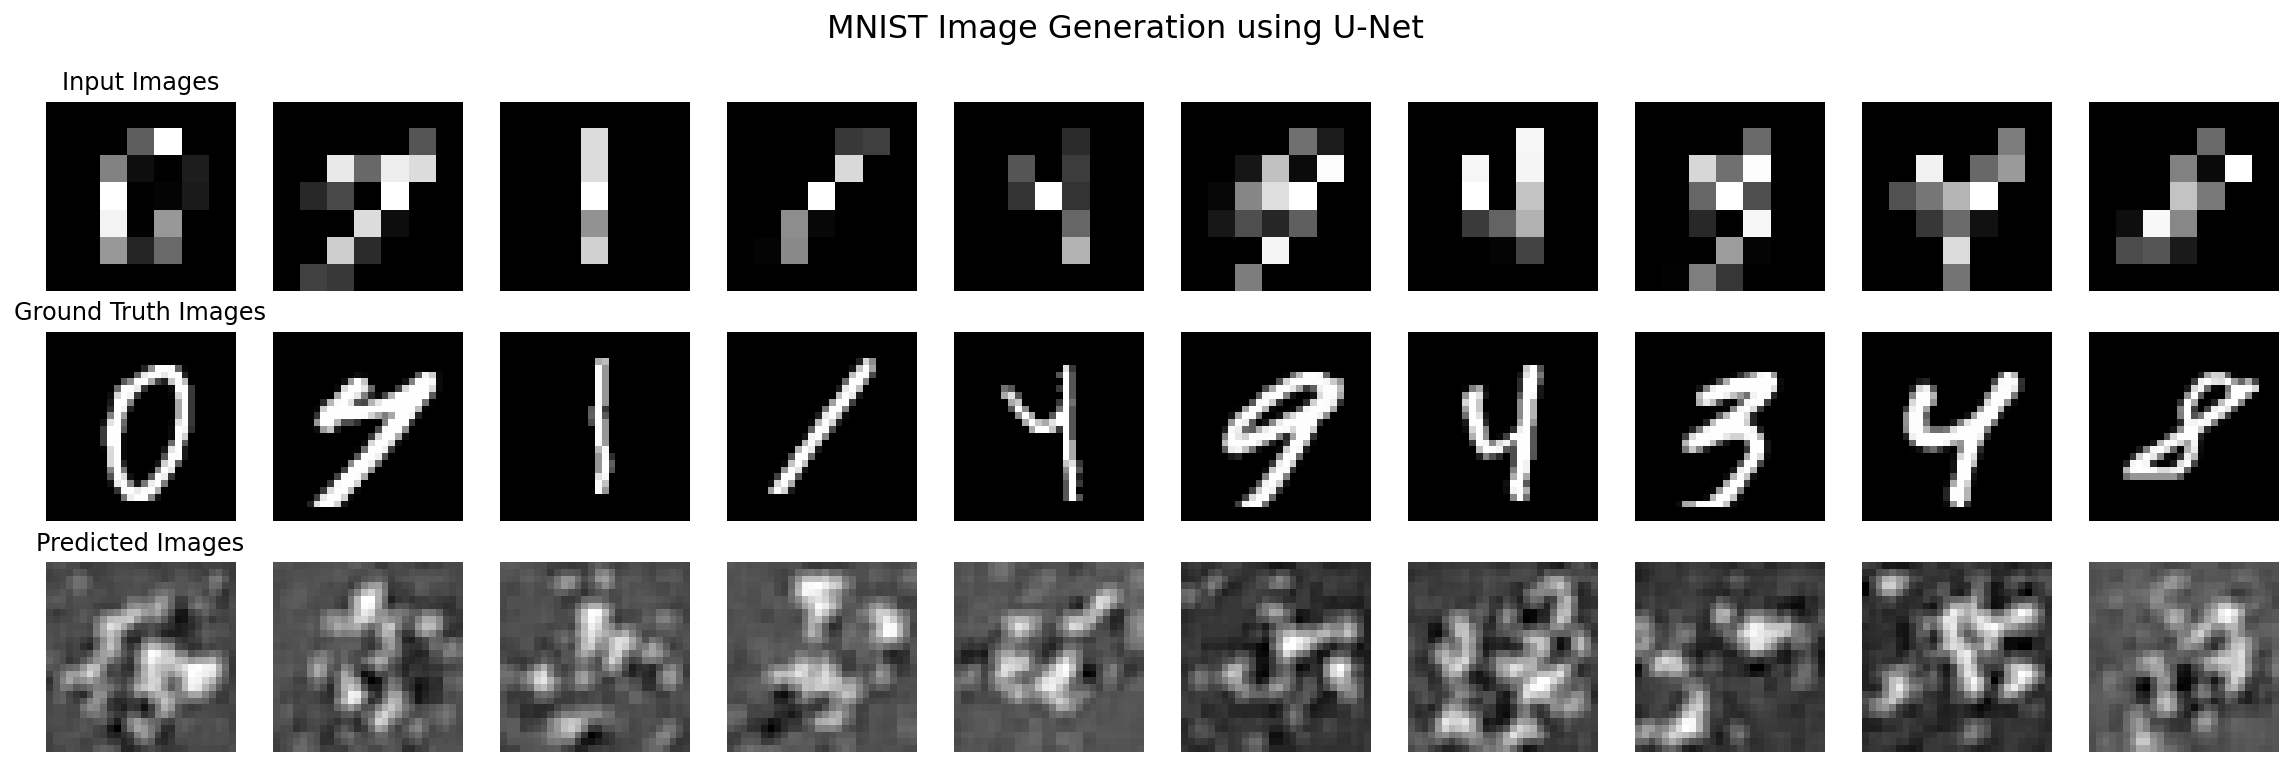

In [143]:
# Get unseen images from the test set
Y_test = mnist.data[1000:1010].reshape(10, 1, 28, 28).float()

# Transfor to size (10, 1, 7, 7)
X_test = transforms.Resize((7, 7))(Y_test)

# Forward pass
Y_hat = model(X_test)

plot_images(X_test, Y_test, Y_hat)
